In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline
import math
import nltk
import string
from itertools import compress
from nltk import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import gensim
from gensim import corpora
from gensim import models
from nltk.util import bigrams
import spacy
from wordcloud import WordCloud
from nltk import word_tokenize, bigrams, trigrams
import umap.umap_ as umap
import plotly.express as px
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine
import networkx as nx
from collections import defaultdict
from itertools import combinations
from nltk.tokenize import word_tokenize  # Requires nltk library, install using `pip install nltk`

C:\Users\cmurua\Anaconda3\envs\Turismo\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\cmurua\Anaconda3\envs\Turismo\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\cmurua\Anaconda3\envs\Turismo\lib\site-packages\umap\distances.py:1086: Num

### Lectura de datos

In [2]:
datos=pd.read_csv('Base de datos/datos_lematizados.csv')
datos['traduccion']=datos['traduccion'].astype(str)
datos = datos.drop(datos.columns[0], axis=1)
datos.head()

,Unnamed: 0,index,Id,placeId,place name,Categoria query,Year,text,stars,Idioma,traduccion,nps,lemmatized
0,0,2,2,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Hermoso atractivo turistico, cuanta con sender...",5.0,es,hermoso atractivo turistico cuanta con sendero...,promotor,hermoso atractivo turistico cuantar con sender...
1,1,4,4,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Muy lindo parque nacional, 100% recomendado, m...",5.0,es,muy lindo parque nacional recomendado muy lind...,promotor,mucho lindo parque nacional recomendado mucho ...
2,2,5,5,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,Excelentes paisajes. Un recorrido muy pulcro y...,5.0,es,excelentes paisajes un recorrido muy pulcro y ...,promotor,excelente paisaje uno recorrido mucho pulcro y...
3,3,6,6,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"hermoso, vengo a este lugar desde el año 1968....",4.0,es,hermoso vengo a este lugar desde el ano lament...,promotor,hermoso venir a este lugar desde el ano lament...
4,4,8,8,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Idiotically crowded, low water levels, mainly ...",1.0,en,estupidamente abarrotado bajos niveles de agua...,detractor,estupidamente abarrotado bajo nivel de agua pr...


### Análisis de datos

**1. Cantidad de Comentarios**

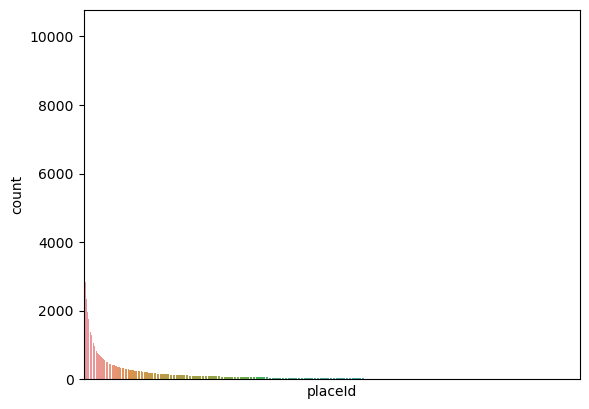

In [3]:
g=sns.countplot(x=datos["placeId"], order = datos["placeId"].value_counts().index)
plt.xticks([],rotation=30)
plt.show()

In [4]:
grouped_data=datos.groupby("placeId")["placeId"].count()  
grouped_data.describe()

count     2635.000000
mean       130.288425
std        423.117981
min          1.000000
25%         13.000000
50%         34.000000
75%         96.000000
max      10260.000000
Name: placeId, dtype: float64

**2. Cantidad de palabras**

In [5]:
# Filter the DataFrame to show only rows with empty spaces
df_filtered = datos[~datos['traduccion'].str.contains(r'^\s*$')]
df_filtered.head()

,Unnamed: 0,index,Id,placeId,place name,Categoria query,Year,text,stars,Idioma,traduccion,nps,lemmatized
0,0,2,2,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Hermoso atractivo turistico, cuanta con sender...",5.0,es,hermoso atractivo turistico cuanta con sendero...,promotor,hermoso atractivo turistico cuantar con sender...
1,1,4,4,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Muy lindo parque nacional, 100% recomendado, m...",5.0,es,muy lindo parque nacional recomendado muy lind...,promotor,mucho lindo parque nacional recomendado mucho ...
2,2,5,5,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,Excelentes paisajes. Un recorrido muy pulcro y...,5.0,es,excelentes paisajes un recorrido muy pulcro y ...,promotor,excelente paisaje uno recorrido mucho pulcro y...
3,3,6,6,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"hermoso, vengo a este lugar desde el año 1968....",4.0,es,hermoso vengo a este lugar desde el ano lament...,promotor,hermoso venir a este lugar desde el ano lament...
4,4,8,8,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Idiotically crowded, low water levels, mainly ...",1.0,en,estupidamente abarrotado bajos niveles de agua...,detractor,estupidamente abarrotado bajo nivel de agua pr...


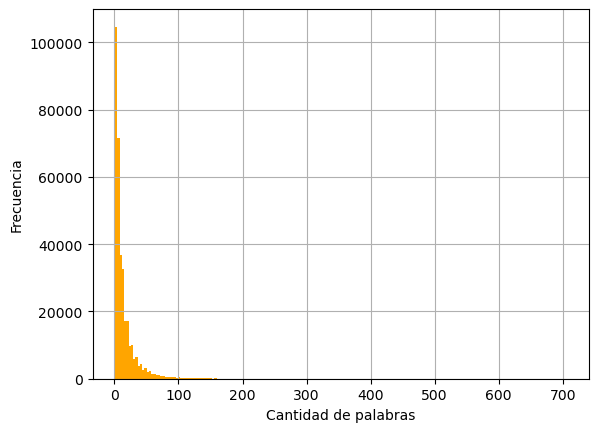

count    343310.000000
mean         14.896266
std          21.596390
min           1.000000
25%           4.000000
50%           8.000000
75%          17.000000
max         705.000000
Name: traduccion, dtype: float64

In [6]:
# Se divide cada texto en la columna 'traduccion' en palabras utilizando el método str.split()
# Luego, se calcula la longitud de cada lista de palabras y se crea un histograma de la cantidad de palabras
df_filtered['traduccion'].str.split().map(lambda x: len(x)).hist(bins=200, color='orange')

# Se agrega etiquetas a los ejes del histograma
plt.xlabel('Cantidad de palabras')
plt.ylabel('Frecuencia')

# Se muestra el histograma
plt.show()

# Se calculan estadísticas descriptivas de la cantidad de palabras en los textos de la columna 'traduccion'
df_filtered['traduccion'].str.split().map(lambda x: len(x)).describe()

**Se filtran aquellos comentarios que tienen menos de tres palabras**

In [7]:
df_filtered['cantidad_palabras']=df_filtered['traduccion'].str.split().map(lambda x: len(x))
df_filtered=df_filtered[df_filtered['cantidad_palabras']>=2]
df_filtered.head()

,Unnamed: 0,index,Id,placeId,place name,Categoria query,Year,text,stars,Idioma,traduccion,nps,lemmatized,cantidad_palabras
0,0,2,2,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Hermoso atractivo turistico, cuanta con sender...",5.0,es,hermoso atractivo turistico cuanta con sendero...,promotor,hermoso atractivo turistico cuantar con sender...,77
1,1,4,4,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Muy lindo parque nacional, 100% recomendado, m...",5.0,es,muy lindo parque nacional recomendado muy lind...,promotor,mucho lindo parque nacional recomendado mucho ...,13
2,2,5,5,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,Excelentes paisajes. Un recorrido muy pulcro y...,5.0,es,excelentes paisajes un recorrido muy pulcro y ...,promotor,excelente paisaje uno recorrido mucho pulcro y...,32
3,3,6,6,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"hermoso, vengo a este lugar desde el año 1968....",4.0,es,hermoso vengo a este lugar desde el ano lament...,promotor,hermoso venir a este lugar desde el ano lament...,29
4,4,8,8,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Idiotically crowded, low water levels, mainly ...",1.0,en,estupidamente abarrotado bajos niveles de agua...,detractor,estupidamente abarrotado bajo nivel de agua pr...,33


**3. Cantidad de caracteres**

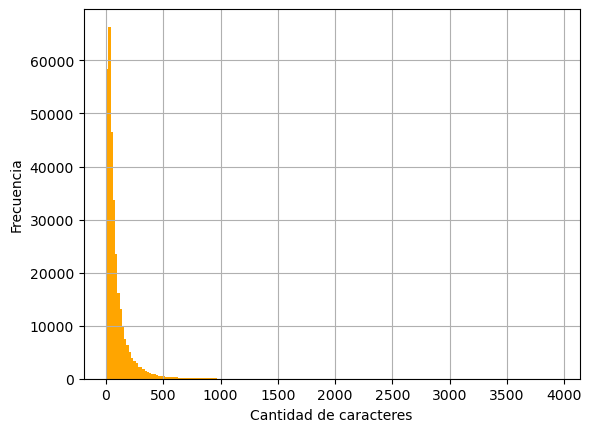

count    315678.000000
mean         93.931614
std         124.547219
min           3.000000
25%          28.000000
50%          55.000000
75%         111.000000
max        3936.000000
Name: traduccion, dtype: float64

In [8]:
# Se calcula el histograma de la longitud de los textos en la columna 'traduccion'
df_filtered['traduccion'].str.len().hist(bins=200, color='orange')

# Se agrega etiquetas a los ejes del histograma
plt.xlabel('Cantidad de caracteres')
plt.ylabel('Frecuencia')

# Se muestra el histograma
plt.show()

# Se calculan estadísticas descriptivas de la longitud de los textos en la columna 'traduccion'
df_filtered['traduccion'].str.len().describe()


### Matriz DTM (matrix of token) con Sklearn

**1. Se definen las stop words**

In [9]:
# Ejecutar solo una vez la siguiente linea de 
#!python -m spacy download es_core_news_sm
#
nlp = spacy.load("es_core_news_sm")

add_stop = ['ser','tener','deber','haber','debe','lugar','hermoso','precioso','lindo','bello','bonito','vale','pena']
for j in add_stop:
    nlp.Defaults.stop_words.add(j)

C:\Users\cmurua\Anaconda3\envs\Turismo\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.6.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


**2. Se tokeniza los comentarios**

In [10]:

def tokenizar(text):
    text = text.lower()
    doc = nlp(text)
    return [str(token) for token in doc if not token.is_punct and not token.is_stop and token.is_alpha]

df_filtered["token"] = df_filtered["traduccion"].apply(tokenizar)
df_filtered.head()

,Unnamed: 0,index,Id,placeId,place name,Categoria query,Year,text,stars,Idioma,traduccion,nps,lemmatized,cantidad_palabras,token
0,0,2,2,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Hermoso atractivo turistico, cuanta con sender...",5.0,es,hermoso atractivo turistico cuanta con sendero...,promotor,hermoso atractivo turistico cuantar con sender...,77,"[atractivo, turistico, senderos, seguros, dist..."
1,1,4,4,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Muy lindo parque nacional, 100% recomendado, m...",5.0,es,muy lindo parque nacional recomendado muy lind...,promotor,mucho lindo parque nacional recomendado mucho ...,13,"[parque, nacional, recomendado, linda, experie..."
2,2,5,5,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,Excelentes paisajes. Un recorrido muy pulcro y...,5.0,es,excelentes paisajes un recorrido muy pulcro y ...,promotor,excelente paisaje uno recorrido mucho pulcro y...,32,"[excelentes, paisajes, recorrido, pulcro, colo..."
3,3,6,6,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"hermoso, vengo a este lugar desde el año 1968....",4.0,es,hermoso vengo a este lugar desde el ano lament...,promotor,hermoso venir a este lugar desde el ano lament...,29,"[vengo, ano, lamentablemente, tenia, agua, qui..."
4,4,8,8,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Idiotically crowded, low water levels, mainly ...",1.0,en,estupidamente abarrotado bajos niveles de agua...,detractor,estupidamente abarrotado bajo nivel de agua pr...,33,"[estupidamente, abarrotado, bajos, niveles, ag..."


**3. Análisis unigrama**

In [11]:

# Crear una nueva lista para almacenar todas las palabras en las listas
all_words = []

# Recorrer la columna 'palabras_lista' para extraer todas las palabras
for lista_palabras in df_filtered["token"]:
    all_words.extend(lista_palabras)

# Crear un DataFrame con las palabras y sus frecuencias
tokens_counts = pd.DataFrame({'token': all_words})
tokens_counts['counts'] = tokens_counts.groupby('token')['token'].transform('count')

tokens_counts = tokens_counts.drop_duplicates().reset_index(drop=True)
tokens_counts = tokens_counts[tokens_counts['counts']>3]
tokens_counts = tokens_counts.sort_values('token')
tokens_counts.head()


,token,counts
49364,aa,5
1013,abajo,298
11145,abandonada,39
17635,abandonadas,11
6954,abandonado,204


**Se grafican las palabras más frecuentes**

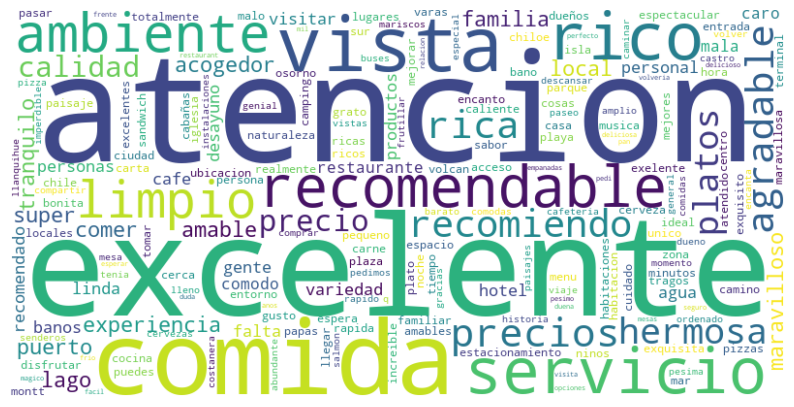

In [12]:
data = dict(zip(tokens_counts['token'].tolist(), tokens_counts['counts'].tolist()))
wc = WordCloud(background_color='white',width=800, height=400, max_words=200).generate_from_frequencies(data)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

**4. Análisis bigrama**

In [13]:
ngramos = []
for _, tokens in df_filtered['token'].iteritems():
    if len(tokens) > 1:
        bi_tokens = [' '.join(x) for x in list(bigrams(tokens))]
        ngramos.extend(bi_tokens)

ngram = pd.DataFrame(list(zip(ngramos)), columns=['ngram'])
ngram_count = ngram['ngram'].value_counts().rename_axis('ngram').reset_index(name='counts')

C:\Users\cmurua\AppData\Local\Temp\ipykernel_15600\2841053609.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _, tokens in df_filtered['token'].iteritems():


**Se grafican los bigramas más frecuentes**

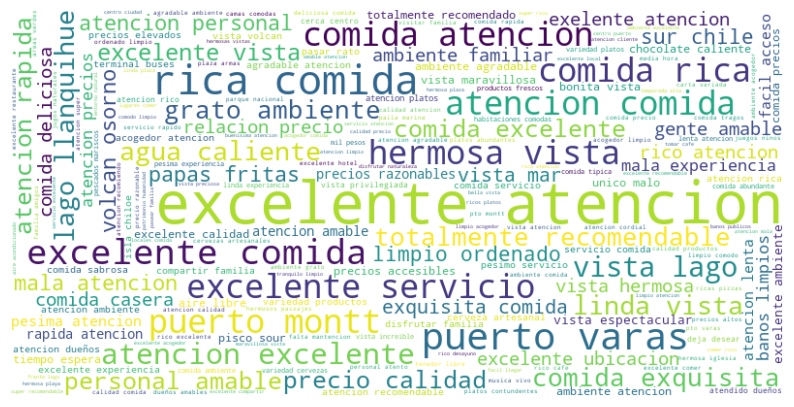

In [14]:
data = dict(zip(ngram_count['ngram'].tolist(), ngram_count['counts'].tolist()))
wc = WordCloud(background_color='white',width=800, height=400, max_words=200).generate_from_frequencies(data)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

**4. Análisis trigrama**

In [15]:
ngramos = []
for _, tokens in df_filtered['token'].iteritems():
    if len(tokens) > 2:  # Check if there are enough tokens for a trigram
        tri_tokens = [' '.join(x) for x in list(trigrams(tokens))]
        ngramos.extend(tri_tokens)

ngram = pd.DataFrame(list(zip(ngramos)), columns=['ngram'])
ngram_count = ngram['ngram'].value_counts().rename_axis('ngram').reset_index(name='counts')

C:\Users\cmurua\AppData\Local\Temp\ipykernel_15600\846611034.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _, tokens in df_filtered['token'].iteritems():


**Se grafican los trigramas más frecuentes**

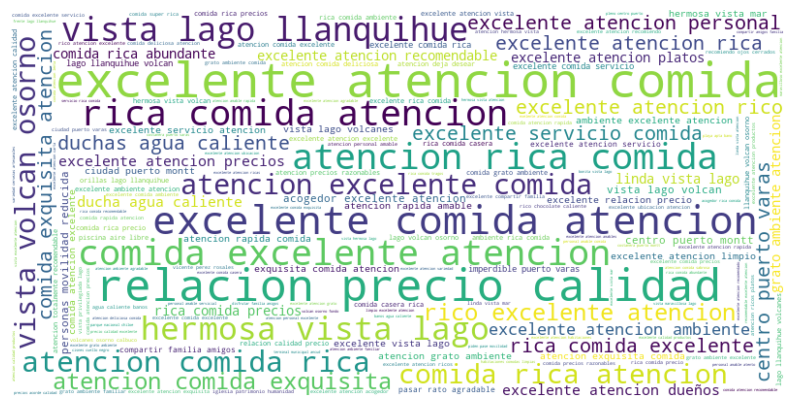

In [16]:
data = dict(zip(ngram_count['ngram'].tolist(), ngram_count['counts'].tolist()))
wc = WordCloud(background_color='white',width=800, height=400, max_words=200).generate_from_frequencies(data)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

**5. Análisis lematización**

In [17]:
# Apply the filter_stopwords function to the 'text' column and create a new 'filtered_text' column

def filter_stopwords(text):
    filtered_words = tokenizar(text)
    return ' '.join(filtered_words)
    
df_filtered['lemmatized_stop'] = df_filtered['lemmatized'].apply(filter_stopwords)

In [18]:

# Define the list of bigrams to replace
bigram_replacements = {
    ('patrimonio', 'humanidad'): 'patrimonio_humanidad',
    ('san', 'francisco'): 'san_francisco',
    ('puerto', 'varas'): 'puerto_varas',
    ('puerto', 'montt'): 'puerto_montt',
    ('plaza', 'arma'): 'plaza_de_armas',
    ('muelle', 'alma'): 'muelle_de_las_almas',
}

# Function to replace bigrams
def replace_with_bigram(text, bigram_replacements):
    words = text.split(' ')
    for bigram_pair, bigram_keyword in bigram_replacements.items():
        bigram_occurrences = [(i, i + 2) for i in range(len(words) - 1) if words[i] == bigram_pair[0] and words[i + 1] == bigram_pair[1]]

        for start, end in reversed(bigram_occurrences):
            words[start:end + 1] = [bigram_keyword]

    return ' '.join(words)

# Replace bigrams in the "text" column
df_filtered['lemmatized_stop_bigramas'] = df_filtered['lemmatized_stop'].apply(lambda x: replace_with_bigram(x, bigram_replacements))
df_filtered.head()



,Unnamed: 0,index,Id,placeId,place name,Categoria query,Year,text,stars,Idioma,traduccion,nps,lemmatized,cantidad_palabras,token,lemmatized_stop,lemmatized_stop_bigramas
0,0,2,2,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Hermoso atractivo turistico, cuanta con sender...",5.0,es,hermoso atractivo turistico cuanta con sendero...,promotor,hermoso atractivo turistico cuantar con sender...,77,"[atractivo, turistico, senderos, seguros, dist...",atractivo turistico cuantar sendero seguro dis...,atractivo turistico cuantar sendero seguro dis...
1,1,4,4,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Muy lindo parque nacional, 100% recomendado, m...",5.0,es,muy lindo parque nacional recomendado muy lind...,promotor,mucho lindo parque nacional recomendado mucho ...,13,"[parque, nacional, recomendado, linda, experie...",parque nacional recomendado experiencia sender...,parque nacional recomendado experiencia sender...
2,2,5,5,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,Excelentes paisajes. Un recorrido muy pulcro y...,5.0,es,excelentes paisajes un recorrido muy pulcro y ...,promotor,excelente paisaje uno recorrido mucho pulcro y...,32,"[excelentes, paisajes, recorrido, pulcro, colo...",excelente paisaje recorrido pulcro colorido co...,excelente paisaje recorrido pulcro colorido co...
3,3,6,6,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"hermoso, vengo a este lugar desde el año 1968....",4.0,es,hermoso vengo a este lugar desde el ano lament...,promotor,hermoso venir a este lugar desde el ano lament...,29,"[vengo, ano, lamentablemente, tenia, agua, qui...",venir ano lamentablemente tenio agua quitar en...,venir ano lamentablemente tenio agua quitar en...
4,4,8,8,ChIJA7e1akBiF5YRGX2D8me8Pnw,Petrohué Waterfalls,tourist attraction,2023,"Idiotically crowded, low water levels, mainly ...",1.0,en,estupidamente abarrotado bajos niveles de agua...,detractor,estupidamente abarrotado bajo nivel de agua pr...,33,"[estupidamente, abarrotado, bajos, niveles, ag...",estupidamente abarrotado nivel agua principalm...,estupidamente abarrotado nivel agua principalm...


### WORD EMBEDDING

**1. Se define el corpus**

In [19]:
%%time
corpus = [text.split() for text in df_filtered['lemmatized_stop_bigramas']]

CPU times: total: 1.16 s
Wall time: 1.16 s


**2. Se entrena un modelo Word2Vec que representa palabras en un espacio vectorial basado en su contexto en un corpus de texto**

In [20]:
model = Word2Vec(corpus, min_count=3,vector_size= 100, window =5, sg = 1)

**Ejemplo 1:**
**Se buscan las palabras más similares a la palabra "castro"de acuerdo al modelo**

In [21]:
model.wv.most_similar('castro')

[('ancud', 0.8167710304260254),
 ('dalcahue', 0.8043055534362793),
 ('achao', 0.7621871829032898),
 ('chonchi', 0.7516064643859863),
 ('puerto_montt', 0.7457035779953003),
 ('quellon', 0.7413923144340515),
 ('queilen', 0.7294031977653503),
 ('ptomontt', 0.7236592173576355),
 ('quinchao', 0.7193652391433716),
 ('chaiten', 0.7098464369773865)]

**Ejemplo 2:**
**Se buscan las palabras más similares a la palabra "iglesia"de acuerdo al modelo**

In [22]:
model.wv.most_similar('iglesia')

[('patrimonio_humanidad', 0.8364621996879578),
 ('patrimonial', 0.7740296721458435),
 ('catolico', 0.754152238368988),
 ('iglesias', 0.7099685668945312),
 ('templo', 0.7061917185783386),
 ('declarado', 0.6891613602638245),
 ('unesco', 0.6868053078651428),
 ('iglesiar', 0.6787129044532776),
 ('capilla', 0.6782864332199097),
 ('cementerio', 0.6756148934364319)]

**Ejemplo 3:**
**Se buscan las palabras más similares a la palabra "trekking"de acuerdo al modelo**

In [24]:
model.wv.most_similar('trekking')

[('caminata', 0.8142068386077881),
 ('trecking', 0.8044931888580322),
 ('senderismo', 0.794008731842041),
 ('tobogán', 0.785807192325592),
 ('sendero', 0.7809054255485535),
 ('dificultad', 0.7737187743186951),
 ('triangulo', 0.7470530867576599),
 ('trayecto', 0.7456327676773071),
 ('laguna', 0.7399727702140808),
 ('complejidad', 0.7386406660079956)]

**3. Atributos modelo**

In [25]:
# Se extraen los vectores de palabras (word vectors) del modelo y 
attribute_vector = model.wv.vectors
print('Dimension del vector de palabra: '+str(model.wv.vectors.shape))

Dimension del vector de palabra: (19313, 100)


In [26]:
# Diccionario donde cada entrada mapea una palabra del vocabulario a su correspondiente índice numérico
model.wv.key_to_index

{'atencion': 0,
 'excelente': 1,
 'comida': 2,
 'rico': 3,
 'precio': 4,
 'servicio': 5,
 'vista': 6,
 'limpio': 7,
 'recomendable': 8,
 'plato': 9,
 'ambiente': 10,
 'maravilloso': 11,
 'amable': 12,
 'local': 13,
 'agradable': 14,
 'recomeir': 15,
 'llegar': 16,
 'bano': 17,
 'exquisito': 18,
 'tranquilo': 19,
 'visitar': 20,
 'acogedor': 21,
 'experiencia': 22,
 'lago': 23,
 'calidad': 24,
 'comer': 25,
 'malo': 26,
 'persona': 27,
 'super': 28,
 'agua': 29,
 'familia': 30,
 'variedad': 31,
 'pasar': 32,
 'adema': 33,
 'personal': 34,
 'recomendado': 35,
 'gente': 36,
 'visto': 37,
 'encantar': 38,
 'restaurante': 39,
 'desayuno': 40,
 'producto': 41,
 'esperar': 42,
 'cafe': 43,
 'caro': 44,
 'comodo': 45,
 'disfrutar': 46,
 'paisaje': 47,
 'atender': 48,
 'cerveza': 49,
 'hotel': 50,
 'pizza': 51,
 'faltar': 52,
 'espectacular': 53,
 'valer': 54,
 'hora': 55,
 'pedir': 56,
 'unico': 57,
 'rapido': 58,
 'sabor': 59,
 'tomar': 60,
 'encontrar': 61,
 'tiempo': 62,
 'zona': 63,
 'natu

In [27]:
#  Vector numérico asociado con la palabra 
model.wv['pudu']

array([-0.29125655, -0.00567509,  0.0610936 ,  0.31374264,  0.5413795 ,
        0.00940465, -0.36477357,  0.3225438 , -0.46078393,  0.03165628,
       -0.26656902, -0.35188994, -0.11793382, -0.11976033, -0.19815823,
       -0.31924546, -0.0945002 , -0.07673724, -0.27073628, -0.1050978 ,
        0.36270058, -0.25771338, -0.7282338 , -0.31820628,  0.5566107 ,
       -0.27548054, -0.3606091 , -0.05929127,  0.09810039,  0.13919799,
       -0.07830369,  0.2707726 ,  0.10252494, -0.2611753 ,  0.06566914,
       -0.48251808, -0.19559   , -0.1746703 ,  0.19691421,  0.13937248,
       -0.32916087, -0.3104137 ,  0.1904681 ,  0.1443165 , -0.07326546,
        0.12178477, -0.09376398,  0.17379689, -0.21361856,  0.00531544,
        0.2788234 , -0.29058662, -0.064057  ,  0.30665112, -0.31414783,
       -0.10297535,  0.09886881, -0.01978609,  0.13372375,  0.32540652,
       -0.02629835,  0.2660666 , -0.22137585, -0.05753133, -0.40961716,
        0.06962721, -0.5590343 ,  0.22018497,  0.3003698 , -0.04

In [28]:
# seleccionar algunos embeddings para mostrar
embeddings_por_proyectar = model.wv.vectors[0:10000]
vocab_por_proyectar = list(model.wv.key_to_index.keys())[0:10000]

# proyectar embeddings usando UMAP.
proyector = umap.UMAP(n_components=2, random_state=10)
proyeccion = proyector.fit_transform(embeddings_por_proyectar)

# crear un dataframe con las proyecciones
df_proyeccion = pd.DataFrame([vocab_por_proyectar, proyeccion[:, 0], proyeccion[:, 1]]).T
df_proyeccion.columns=['palabra', 'x', 'y']

In [29]:
def exec_query(modelo, palabra, topn):
    """dada una palabra, encuentra y proyecta sus similares."""
    
    # calcular palabras similares
    similares = modelo.wv.most_similar(palabra, topn)
    #model.wv.most_similar('iglesia')
    # proyectar palabra query
    proyeccion = proyector.transform([model.wv[palabra]])
    query = [{
        'palabra': palabra, 
        'x': proyeccion[0, 0],
        'y': proyeccion[0, 1],
        'similitud': 1,            
    }]
        
    # proyectar palabras similares
    for word, sim in similares:
        proyeccion = proyector.transform([model.wv[word]])
        query.append({
            'palabra': word, 
            'x': proyeccion[0, 0], 
            'y': proyeccion[0, 1],
            'similitud': sim,
        })
    
    df_query = pd.DataFrame(query)
    
    return df_query

def plot_embeddings(model, projections, query=None, topn=20,path='Figuras/fig.html'):
    """coordina la creación de los gráficos de proyecciones de embeddings"""

    if query is not None: 
        
        if query not in model.wv:
            raise ValueError('No existe la palabra en el modelo')
        
        df_query = exec_query(model, query, topn=topn)
        display(df_query)
        plot_df = df_query.fillna(0).drop_duplicates(subset='palabra')
        plot_df['tamaño'] = plot_df['similitud'].apply(lambda x: 2 if x <= 0.001 else 20)
        title=f'Proyección de los Embeddings mas similares a {query}'

    else: 
        plot_df = projections.loc[0:10000]
        title='Proyección de los primeros 10.000 Word Embeddings'

    fig = px.scatter(
        plot_df, 
        x='x', 
        y='y', 
        hover_name='palabra',
        range_x=(projections['x'].min() - 1, projections['x'].max() + 1),
        range_y=(projections['y'].min() - 1, projections['y'].max() + 1),
        color='similitud' if query is not None else None,
        title=title,
    )

    if query is not None:
        fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
        fig.add_trace(px.scatter(
            projections.loc[0:10000],
            x='x',
            y='y', 
            hover_name='palabra',
            opacity=0.2).data[0])
    
    fig.write_html(path)

In [30]:
plot_embeddings(model, df_proyeccion,path='Figuras/Proyeccion_10000_words.html')

In [31]:
plot_embeddings(model, df_proyeccion, 'iglesia',topn=10,path='Figuras/Proyeccion_iglesia.html')

,palabra,x,y,similitud
0,iglesia,3.321127,1.502808,1.000000
1,patrimonio_humanidad,3.367676,1.505384,0.508271
2,patrimonial,3.323627,1.499670,0.397347
3,catolico,3.250196,1.526209,0.390288
4,declarado,3.301366,1.568498,0.372816
5,templo,3.282871,1.554270,0.347146
6,campanario,3.056535,1.577634,0.342311
7,monumento,3.348428,1.548976,0.341114
8,faro,2.278930,1.251013,0.337466
9,santa,2.543540,1.651885,0.332220


In [32]:
plot_embeddings(model, df_proyeccion, 'pudu',topn=10,path='Figuras/Proyeccion_pudu.html')

,palabra,x,y,similitud
0,pudu,2.105419,-0.145112,1.000000
1,zorro,2.334544,-0.382518,0.495449
2,calzoncillo,1.297536,-0.195518,0.462115
3,salto,1.261887,-0.449492,0.454494
4,indio,0.984172,-0.162484,0.454200
5,princesa,0.923050,-0.159206,0.453336
6,anticura,0.957647,-0.140830,0.406662
7,zorrito,1.546825,-0.251749,0.405757
8,arcoiris,1.170258,-0.102454,0.394980
9,laguna,0.916823,-0.448544,0.389130


In [33]:
plot_embeddings(model, df_proyeccion, 'alerce',path='Figuras/Proyeccion_alerce.html')

,palabra,x,y,similitud
0,alerce,1.178110,-0.411669,1.000000
1,cipr,2.925649,1.413636,0.424867
2,milenario,1.185647,-0.500341,0.422851
3,alerz,1.415212,-0.432974,0.411409
4,helecho,1.944657,-0.520921,0.395321
5,glaciar,1.508598,-0.351317,0.388746
6,manio,2.215844,0.536126,0.379217
7,calentamiento,1.121465,0.694172,0.369297
8,nous,7.824926,3.872547,0.358133
9,lava,1.466391,-0.216871,0.353663


### Network

**1. Matriz de similitud**

In [34]:
target_words = ['iglesia', 'castro']

# Get the words in the vocabulary
vocab = list(model.wv.key_to_index.keys())

# Create an empty similarity matrix
similarity_matrix = np.zeros((len(target_words), len(vocab)))

# Compute the similarity between each pair of words
for i, word1 in enumerate(target_words):
    for j, word2 in enumerate(vocab):
        similarity_matrix[i, j] = 1 - cosine(model.wv[word1], model.wv[word2])

print(similarity_matrix)


[[0.13952924 0.20774747 0.20144936 ... 0.39378625 0.28727251 0.45714334]
 [0.34497926 0.46882185 0.30940509 ... 0.45750073 0.42968303 0.39686576]]


In [35]:
# Set the similarity threshold (adjust this based on your preference)
similarity_threshold = 0.7

# Filter word pairs based on the similarity threshold
edges = []
for i, word1 in enumerate(target_words):
    for j, word2 in enumerate(vocab):
        # Exclude the diagonal and filter based on the similarity threshold
        if i != j and similarity_matrix[i, j] >= similarity_threshold:
            edges.append((word1, word2))
print('Nodos de la red')
print(edges)

Nodos de la red
[('iglesia', 'iglesia'), ('iglesia', 'patrimonio_humanidad'), ('iglesia', 'patrimonial'), ('iglesia', 'catolico'), ('iglesia', 'templo'), ('iglesia', 'iglesias'), ('castro', 'puerto_montt'), ('castro', 'castro'), ('castro', 'puerto_varas'), ('castro', 'ancud'), ('castro', 'dalcahue'), ('castro', 'quellon'), ('castro', 'chonchi'), ('castro', 'achao'), ('castro', 'quinchao'), ('castro', 'chaiten'), ('castro', 'queilen'), ('castro', 'ptomontt')]


**2. Grafo**

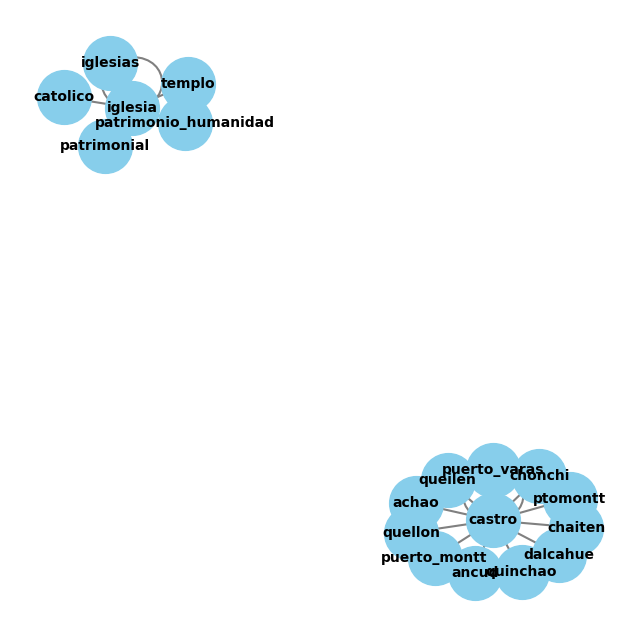

In [36]:
# Create a graph
G = nx.Graph()
G.add_edges_from(edges)

# Create a new figure and axis
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Positions nodes using the spring layout algorithm
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10, font_weight='bold', edge_color='gray', width=1.5, ax=ax)

# Show the plot
plt.show()

**3. Matriz de co-ocurrencia con ventana de 2 palabras**

In [37]:
def generate_co_occurrence_network(texts, window_size):
    graph = nx.Graph()
    co_occurrence_count = defaultdict(int)

    for text in texts:
        words = tokenizar(text)

        for i, word in enumerate(words):
            start_idx = max(0, i - window_size)
            end_idx = min(len(words), i + window_size + 1)
            context = words[start_idx:end_idx]

            for pair in combinations(context, 2):
                co_occurrence_count[pair] += 1

    for (word1, word2), count in co_occurrence_count.items():
        graph.add_edge(word1, word2, weight=count)

    return graph

def plot_co_occurrence_network(graph):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, k=0.5, iterations=50)
    node_sizes = [len(graph[node]) * 300 for node in graph.nodes()]
    edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]

    nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color='skyblue')
    nx.draw_networkx_edges(graph, pos, width=edge_weights, edge_color='gray')
    nx.draw_networkx_labels(graph, pos, font_size=10, font_family='sans-serif')

    plt.axis('off')
    plt.title("Co-occurrence Network Word Plot")
    plt.show()



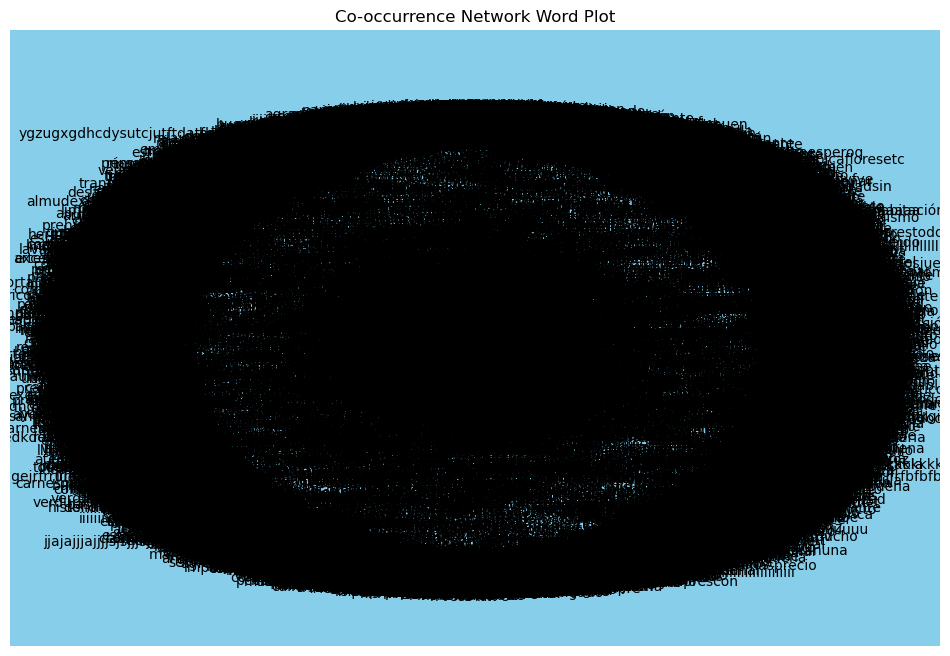

In [38]:
# Extract texts from the DataFrame
texts = df_filtered['lemmatized_stop_bigramas'].tolist()

# Generate the co-occurrence network
co_occurrence_graph = generate_co_occurrence_network(texts, 2)

# Plot the co-occurrence network
plot_co_occurrence_network(co_occurrence_graph)

#Componente gigante
G=co_occurrence_graph


In [39]:
compon=[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
compon
print('Non connected: '+ str(sum(compon)-compon[0]))
print('Connected nodes en la compoenente gigante: '+ str(compon[0]) +' de '+str(G.number_of_nodes())+' nodos totales.')

print(compon)


# Let's extract and use only the giant component
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

Non connected: 165
Connected nodes en la compoenente gigante: 67565 de 67730 nodos totales.
[67565, 10, 9, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]


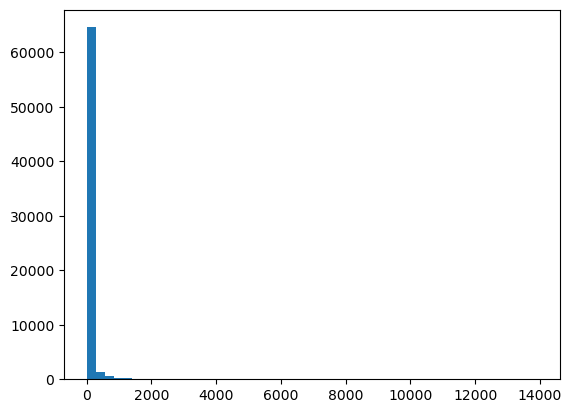

In [40]:
F = S[0]
dict1=dict(F.degree())  # node 0 has degree 1
sorted_dict = {}
sorted_keys = sorted(dict1, key=dict1.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_dict[w] = dict1[w]

#plt.hist((dict1.values()), bins=np.logspace(0,3))
#plt.loglog()
plt.hist((dict1.values()), bins=50)
plt.show()

In [41]:
N10 = len(F)
L10 = F.size()
degrees10 = list(dict(F.degree()).values())
kmin10 = min(degrees10)
kmax10 = max(degrees10)
print("Número de nodos: ", N10)
print("Número de enlaces: ", L10)
print('-------')
print("Grado promedio: ", 2*L10/N10) 
print('-------')
print("Grado mínimo: ", kmin10)
print("Grado máximo: ", kmax10)
print('-------')
print('Densidad: ', nx.density(F))
#print('Diametro: ',nx.diameter(F))

#nx.draw_networkx(F)

Número de nodos:  67565
Número de enlaces:  2170610
-------
Grado promedio:  64.2524975949086
-------
Grado mínimo:  1
Grado máximo:  13928
-------
Densidad:  0.000950987176527568


In [42]:
def filter_network(graph, threshold):
    # Create a new filtered graph with node names conserved
    filtered_graph = nx.Graph()

    for node_i in graph.nodes():
        for node_j in graph.nodes():
            if graph.has_edge(node_i, node_j):
                weight = graph[node_i][node_j].get("weight", 0)  # Get edge weight, default to 0
                if weight >= threshold:
                    filtered_graph.add_edge(node_i, node_j, weight=weight)

    return filtered_graph



# Example usage:
# Let's say you have a graph 'F' with node names and an associated threshold value.
# Set the threshold value you want to use for filtering, for example, 0.5.
threshold_value = 50
network = filter_network(F, threshold_value)


In [43]:
N10 = len(network)
L10 = network.size()
degrees10 = list(dict(network.degree()).values())
kmin10 = min(degrees10)
kmax10 = max(degrees10)
print("Número de nodos: ", N10)
print("Número de enlaces: ", L10)
print('-------')
print("Grado promedio: ", 2*L10/N10) 
print('-------')
print("Grado mínimo: ", kmin10)
print("Grado máximo: ", kmax10)
print('-------')
print('Densidad: ', nx.density(network))

Número de nodos:  1823
Número de enlaces:  13426
-------
Grado promedio:  14.729566648381788
-------
Grado mínimo:  1
Grado máximo:  604
-------
Densidad:  0.008084284658826449


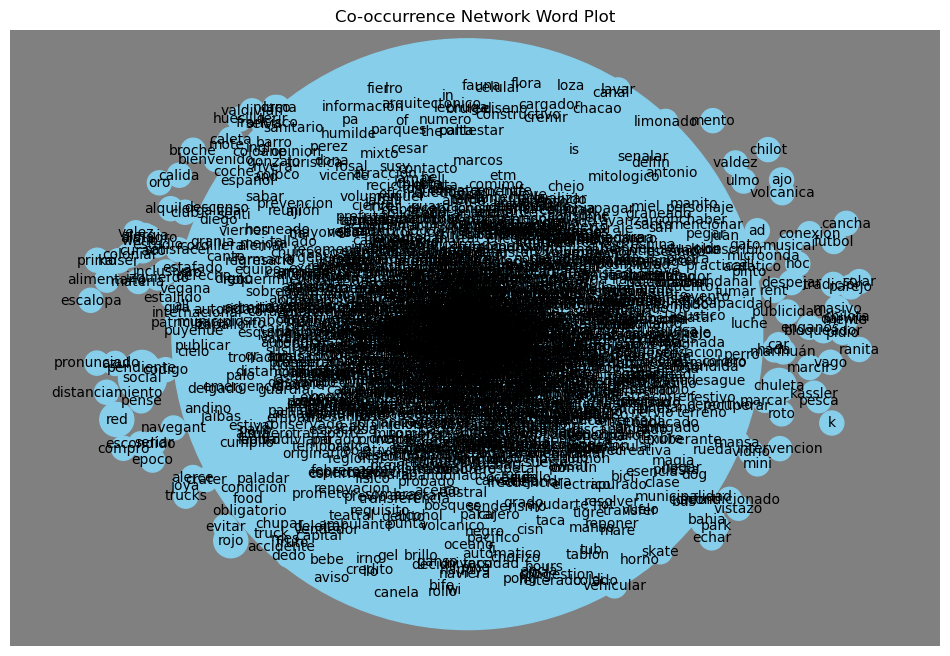

In [44]:
# Plot the co-occurrence network
plot_co_occurrence_network(network)

In [45]:
nx.write_gexf(network, "Resultados/Red_Filtrada_Palabras.gexf")

**4. Matriz de co-ocurrencia con ventana de 5 palabras**

In [46]:
# Extract texts from the DataFrame
texts = df_filtered['lemmatized_stop_bigramas'].tolist()

# Generate the co-occurrence network
co_occurrence_graph_5 = generate_co_occurrence_network(texts, 5)


In [47]:
G1=co_occurrence_graph_5

In [48]:
compon=[len(c) for c in sorted(nx.connected_components(G1), key=len, reverse=True)]
compon
print('Non connected: '+ str(sum(compon)-compon[0]))
print('Connected nodes en la compoenente gigante: '+ str(compon[0]) +' de '+str(G1.number_of_nodes())+' nodos totales.')

print(compon)



# Let's extract and use only the giant component
S1= [G1.subgraph(c).copy() for c in nx.connected_components(G1)]

Non connected: 165
Connected nodes en la compoenente gigante: 67565 de 67730 nodos totales.
[67565, 10, 9, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]


In [49]:
F1 = S1[0]

In [50]:
# Example usage:
# Let's say you have a graph 'F' with node names and an associated threshold value.
# Set the threshold value you want to use for filtering, for example, 0.5.
threshold_value = 150
network1 = filter_network(F1, threshold_value)

In [51]:
N10 = len(network1)
L10 = network.size()
degrees10 = list(dict(network1.degree()).values())
kmin10 = min(degrees10)
kmax10 = max(degrees10)
print("Número de nodos: ", N10)
print("Número de enlaces: ", L10)
print('-------')
print("Grado promedio: ", 2*L10/N10) 
print('-------')
print("Grado mínimo: ", kmin10)
print("Grado máximo: ", kmax10)
print('-------')
print('Densidad: ', nx.density(network1))

Número de nodos:  1543
Número de enlaces:  13426
-------
Grado promedio:  17.40246273493195
-------
Grado mínimo:  1
Grado máximo:  800
-------
Densidad:  0.016177826643567494


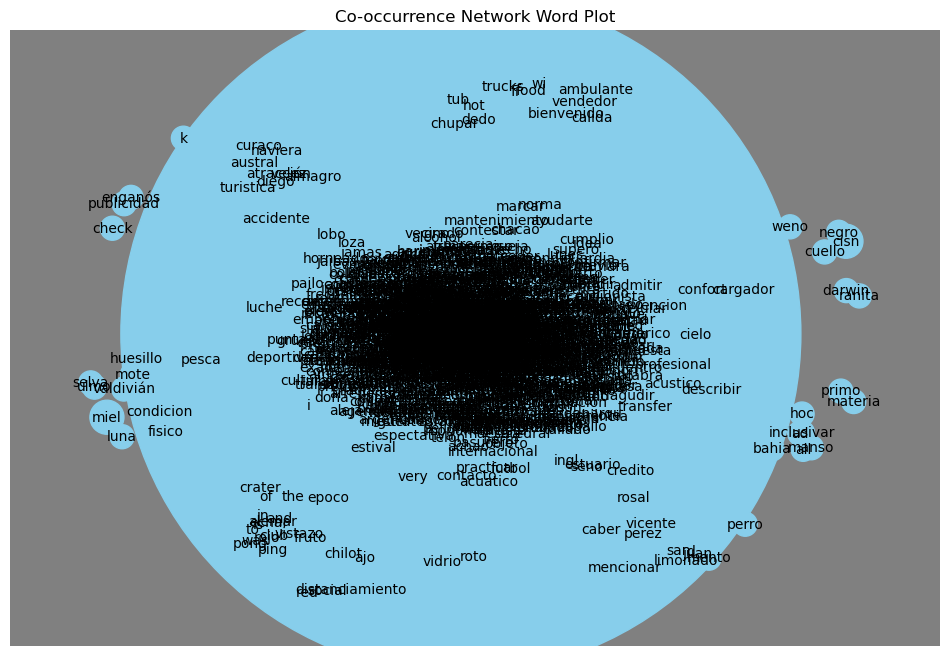

In [52]:
# Plot the co-occurrence network
plot_co_occurrence_network(network1)

In [53]:
nx.write_gexf(network1, "Resultados/Red_Filtrada_Palabras_5.gexf")